# 🧩 Dataset Overview

This dataset contains **pressure distribution maps** representing five posture positions.  
Each image is a heatmap where **color intensity** indicates **pressure**:
- 🔴 High pressure
- 🔵 Low or no pressure

---

## 📚 Posture Classes
- **Left** – Lying on the left side  
- **Right** – Lying on the right side  
- **Supine** – Lying on the back  
- **Prone** – Lying face down  
- **OOB (Out of Bed)** – No subject or off the mat  

# Data Ingestion


In [98]:
# libraries
import os
from PIL import Image
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import json

In [99]:
# Define root directory and classes
root_dir = "Task_1_data"
CLASSES = ["left", "right", "supine", "outofbed", "prone"]

In [100]:
class PressureDistributionDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.samples = []
        self.skipped = []
        self.counter = 0

        # Folders aren't properly labeled so we need to assign labels based on file name.
        for subdir, _, files in os.walk(root_dir):
            for f in files:
                fpath = os.path.join(subdir, f)
                if f.endswith(".jpg"):

                    label = self.extract_label(f)
                    if label is not None:
                        label_indx = CLASSES.index(label)
                        self.samples.append((fpath, label_indx))
                else:
                    self.counter += 1
                    self.skipped.append(fpath)
        print(f"Skipped {self.counter} non-jpg files.")

    def extract_label(self, filename):
        # Extract label from filename
        filename = filename.lower()
        for c_name in CLASSES:
            if filename.startswith(c_name):
                return c_name
        return None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

    def return_random_sample(self):
        indx = random.randint(0, len(self.samples) - 1)
        return self.__getitem__(indx)

    def get_skipped_files(self):
        return self.skipped

# Functions for MLFLOW metrics

In [101]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tempfile


def log_classification_report_html(c_report, model_name="Model"):
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(c_report).transpose().round(3)

    # --- Styled HTML ---
    html = f"""
    <html>
    <head>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 40px;
                background-color: #f9f9f9;
            }}
            h2 {{
                text-align: center;
                color: #333;
            }}
            table {{
                border-collapse: collapse;
                width: 80%;
                margin: 20px auto;
                box-shadow: 0 2px 8px rgba(0,0,0,0.1);
                background-color: white;
            }}
            th, td {{
                border: 1px solid #ccc;
                padding: 10px 15px;
                text-align: center;
            }}
            th {{
                background-color: #007BFF;
                color: white;
                font-weight: bold;
            }}
            tr:nth-child(even) {{
                background-color: #f2f2f2;
            }}
            tr:hover {{
                background-color: #eaf3ff;
            }}
        </style>
    </head>
    <body>
        <h2>Classification Report for {model_name}</h2>
        {df_report.to_html(index=True, classes='styled-table', border=0)}
    </body>
    </html>
    """

    # --- Write to a temporary file and log it as artifact ---
    with tempfile.NamedTemporaryFile("w", suffix=".html", delete=False) as tmp:
        tmp.write(html)
        tmp.flush()
        mlflow.log_artifact(tmp.name, artifact_path="reports")

## Baseline SVC with grayscale filter

In [13]:
# Define transforms
# 58x130 is the size of the images in the dataset
# Converting to grayscale to try and simplyfy the model
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
    ]
)

In [14]:
train_path = os.path.join(root_dir, "TRAIN")
dataset = PressureDistributionDataset(train_path, CLASSES, transform=transform)

print(f"Total samples in dataset: {len(dataset)}")
dataset.get_skipped_files()

Skipped 1 non-jpg files.
Total samples in dataset: 3775


['Task_1_data/TRAIN/.DS_Store']

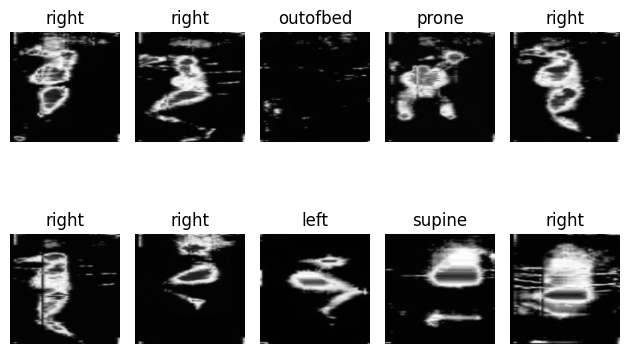

In [15]:
for i in range(10):
    img, label = dataset.return_random_sample()
    np_img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 5, i + 1)
    plt.imshow(np_img.squeeze(), cmap="gray")
    plt.title(CLASSES[label])
    plt.axis("off")


plt.tight_layout()
plt.show()

In [16]:
# Splitting the dataset into training, validation and test sets

train_split = int(0.8 * len(dataset))
val_split = len(dataset) - train_split

train_ds, val_ds = random_split(dataset, [train_split, val_split])
test_ds = PressureDistributionDataset(
    os.path.join(root_dir, "VALIDATION"), classes=CLASSES, transform=transform
)

print(f"Training samples : {len(train_ds)}")
print(f"Validation samples : {len(val_ds)}")
print(f"Test samples : {len(test_ds)}")

Skipped 1 non-jpg files.
Training samples : 3020
Validation samples : 755
Test samples : 1554


# Baseline Models 

## SVM 

Simple SVM baseline - other models should almost always perform better.

Flatten the image and pass it into an Support Vector Classifier

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import mlflow
import joblib

In [84]:
X, y = [], []

# flatten train images
for img, label in train_ds:
    X.append(img.view(-1).numpy())  # flatten the image
    y.append(label)

# flatten validation images
X_val, y_val = [], []
for img, label in val_ds:
    X_val.append(img.view(-1).numpy())  # flatten the image
    y_val.append(label)

clf = SVC(kernel="linear", class_weight="balanced")  # using linear kernel

In [85]:
import numpy as np

y = np.array(y)
unique_labels, counts = np.unique(y, return_counts=True)

print("Unique labels found:", unique_labels)
for i, c in zip(unique_labels, counts):
    print(f"{CLASSES[i]}: {c} samples")

Unique labels found: [0 1 2 3 4]
left: 335 samples
right: 1053 samples
supine: 581 samples
outofbed: 772 samples
prone: 279 samples


In [86]:
clf.fit(X, y)
preds = clf.predict(X_val)
model_path = os.path.join("models", "baseline_svc_model.pkl")
try:
    joblib.dump(clf, model_path)
    print("SVC model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

SVC model saved successfully.


In [87]:
mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="Baseline_Grayscale_SVC"):
    preds = clf.predict(X_val)
    report = classification_report(y_val, preds, target_names=CLASSES, output_dict=True)

    mlflow.log_params(
        {
            "model": "SVC",
            "kernel": "rbf",
        }
    )

    # log scalar metrics
    mlflow.log_metrics(
        {
            "f1_macro": round(report["macro avg"]["f1-score"], 3),
            "accuracy": round(report["accuracy"], 3),
        }
    )

    # log classification report as HTML
    log_classification_report_html(report, model_name="Baseline_Grayscale_SVC")

## Simple CNN

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BaselineCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BaselineCNN, self).__init__()

        # Grayscale input: 1 channel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # After 3 poolings: 256 → 128 → 64 → 32
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (1→32)
        x = self.pool(F.relu(self.conv2(x)))  # (32→64)
        x = self.pool(F.relu(self.conv3(x)))  # (64→128)
        x = x.view(x.size(0), -1)  # flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [51]:
from torch.utils.data import DataLoader

batch_size = 64  # you can adjust this depending on your GPU/CPU

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [53]:
import mlflow
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="CNN_Baseline"):
    mlflow.log_params({"model": "CNN", "epochs": epochs, "lr": 1e-3})

    # --- Training loop ---
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

    # --- Final Evaluation ---
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    # Compute metrics once at the end
    report = classification_report(
        y_true=val_true, y_pred=val_preds, target_names=CLASSES, output_dict=True
    )
    val_acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    # Log metrics to MLflow
    mlflow.log_metrics(
        {"val_accuracy": round(val_acc, 3), "val_macro_f1": round(macro_f1, 3)}
    )

    log_classification_report_html(report, model_name="Baseline_Grayscale_CNN")
    # Save model
    torch.save(model.state_dict(), "models/cnn_grayscale_baseline.pth")

Epoch 1/5 - Loss: 0.6157
Epoch 2/5 - Loss: 0.2219
Epoch 3/5 - Loss: 0.1548
Epoch 4/5 - Loss: 0.1184
Epoch 5/5 - Loss: 0.0923


In [54]:
# Testing on testing data
with torch.no_grad():
    test_preds, test_true = [], []
    model.eval()
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

    print("\nTest Classification Report:")
    print(classification_report(test_true, test_preds, target_names=CLASSES))


Test Classification Report:
              precision    recall  f1-score   support

        left       0.79      0.86      0.83        88
       right       0.97      0.98      0.97       671
      supine       0.91      0.88      0.90       242
    outofbed       1.00      1.00      1.00       472
       prone       0.95      0.89      0.92        81

    accuracy                           0.96      1554
   macro avg       0.92      0.92      0.92      1554
weighted avg       0.96      0.96      0.96      1554



# Advanced Models

CNN and SVM already provides a good baseline that has very acceptable results however, let us try more advanced models for observation and analysis

## Update the transforms

In [56]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
        transforms.RandomApply([transforms.RandomAdjustSharpness(2)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.15),  # moved to the end
    ]
)


eval_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [57]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Load dataset once (no transform yet)
dataset_rgb = PressureDistributionDataset(train_path, CLASSES, transform=None)

# Extract labels for stratified split
labels = [label for _, label in dataset_rgb]

# Split indices for train/validation
train_idx, val_idx = train_test_split(
    list(range(len(dataset_rgb))), test_size=0.2, stratify=labels, random_state=42
)

# Apply separate transforms to each subset
train_ds_rgb = Subset(
    PressureDistributionDataset(train_path, CLASSES, transform=train_transform),
    train_idx,
)
val_ds_rgb = Subset(
    PressureDistributionDataset(train_path, CLASSES, transform=eval_transform), val_idx
)

# Test set (from external VALIDATION folder)
test_ds_rgb = PressureDistributionDataset(
    os.path.join(root_dir, "VALIDATION"), CLASSES, transform=eval_transform
)

Skipped 1 non-jpg files.
Skipped 1 non-jpg files.
Skipped 1 non-jpg files.
Skipped 1 non-jpg files.


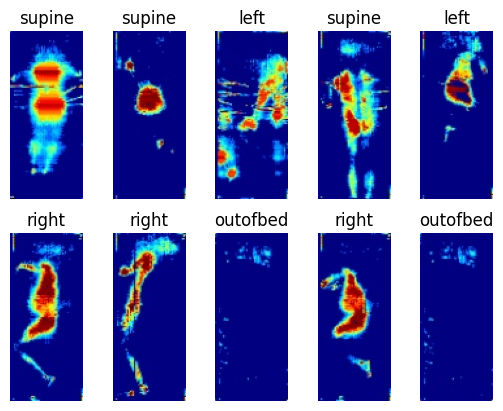

In [60]:
for i in range(10):
    img, label = dataset_rgb.return_random_sample()

    # Convert to NumPy directly (PIL → np.array)
    np_img = np.array(img)

    plt.subplot(2, 5, i + 1)
    plt.imshow(np_img, cmap="gray")
    plt.title(CLASSES[label])
    plt.axis("off")

plt.show()

In [61]:
batch_size = 32

train_loader_rgb = DataLoader(train_ds_rgb, batch_size=batch_size, shuffle=True)
val_loader_rgb = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False)
test_loader_rgb = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False)

In [63]:
# Define a function to count dataset classes
from collections import Counter


def get_class_counts(loader, class_names):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.tolist())
    counts = Counter(all_labels)
    print("\n📊 Class counts:")
    for i, cls in enumerate(class_names):
        print(f"{cls:<10}: {counts.get(i, 0)}")

In [64]:
get_class_counts(train_loader_rgb, CLASSES)
get_class_counts(val_loader_rgb, CLASSES)
get_class_counts(test_loader_rgb, CLASSES)


📊 Class counts:
left      : 336
right     : 1052
supine    : 582
outofbed  : 779
prone     : 271

📊 Class counts:
left      : 84
right     : 263
supine    : 146
outofbed  : 194
prone     : 68

📊 Class counts:
left      : 88
right     : 671
supine    : 242
outofbed  : 472
prone     : 81


## MobileNet_V3_small

In [65]:
from torchvision import models
from tqdm import tqdm

model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(CLASSES))
model = model.to(device)

In [68]:
import mlflow
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

num_epochs = 25
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print("Using device:", device)

mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="MobileNetV3_Small"):
    mlflow.log_params({"model": "MobileNetV3_Small", "epochs": num_epochs, "lr": 1e-4})

    # --- Training loop ---
    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)
        print(f"Train Loss: {avg_train_loss:.4f}")

    # --- Final Evaluation ---
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader_rgb, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    # --- Compute metrics once ---
    report = classification_report(
        y_true=val_true, y_pred=val_preds, target_names=CLASSES, output_dict=True
    )
    val_acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    mlflow.log_metrics(
        {"val_accuracy": round(val_acc, 3), "val_macro_f1": round(macro_f1, 3)}
    )

    log_classification_report_html(report, model_name="MobileNetV3_Small")

    # --- Save model ---
    torch.save(model.state_dict(), "models/mobilenetv3_small.pth")

Using device: mps

🚀 Epoch 1/25


Training: 100%|██████████| 95/95 [00:58<00:00,  1.62it/s]


Train Loss: 0.2411

🚀 Epoch 2/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.02it/s]


Train Loss: 0.2435

🚀 Epoch 3/25


Training: 100%|██████████| 95/95 [00:19<00:00,  4.96it/s]


Train Loss: 0.2389

🚀 Epoch 4/25


Training: 100%|██████████| 95/95 [00:21<00:00,  4.38it/s]


Train Loss: 0.2426

🚀 Epoch 5/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.07it/s]


Train Loss: 0.2418

🚀 Epoch 6/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.12it/s]


Train Loss: 0.2438

🚀 Epoch 7/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.06it/s]


Train Loss: 0.2422

🚀 Epoch 8/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.12it/s]


Train Loss: 0.2392

🚀 Epoch 9/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.12it/s]


Train Loss: 0.2403

🚀 Epoch 10/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.09it/s]


Train Loss: 0.2393

🚀 Epoch 11/25


Training: 100%|██████████| 95/95 [00:19<00:00,  5.00it/s]


Train Loss: 0.2390

🚀 Epoch 12/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.11it/s]


Train Loss: 0.2403

🚀 Epoch 13/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.10it/s]


Train Loss: 0.2376

🚀 Epoch 14/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.07it/s]


Train Loss: 0.2404

🚀 Epoch 15/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.04it/s]


Train Loss: 0.2394

🚀 Epoch 16/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.08it/s]


Train Loss: 0.2391

🚀 Epoch 17/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.13it/s]


Train Loss: 0.2362

🚀 Epoch 18/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.09it/s]


Train Loss: 0.2355

🚀 Epoch 19/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.10it/s]


Train Loss: 0.2340

🚀 Epoch 20/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.10it/s]


Train Loss: 0.2402

🚀 Epoch 21/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.06it/s]


Train Loss: 0.2343

🚀 Epoch 22/25


Training: 100%|██████████| 95/95 [00:19<00:00,  4.95it/s]


Train Loss: 0.2383

🚀 Epoch 23/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.01it/s]


Train Loss: 0.2355

🚀 Epoch 24/25


Training: 100%|██████████| 95/95 [00:18<00:00,  5.05it/s]


Train Loss: 0.2364

🚀 Epoch 25/25


Training: 100%|██████████| 95/95 [00:37<00:00,  2.55it/s]


Train Loss: 0.2378


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.23it/s]


In [71]:
# Testing on testing data
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader_rgb, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

Testing: 100%|██████████| 49/49 [00:16<00:00,  2.96it/s]

📊 Classification Report:
              precision    recall  f1-score   support

        left       0.92      0.91      0.91        88
       right       0.98      0.97      0.98       671
      supine       0.91      0.93      0.92       242
    outofbed       1.00      1.00      1.00       472
       prone       0.95      0.95      0.95        81

    accuracy                           0.97      1554
   macro avg       0.95      0.95      0.95      1554
weighted avg       0.97      0.97      0.97      1554



### Fine-tuned MobileNetV3Small

In [74]:
from torchvision import models
from tqdm import tqdm
from torch import nn
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(CLASSES))
model = model.to(device)

Adding scheduler for dynamic Learning rate

In [76]:
import mlflow
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

num_epochs = 25
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Using device:", device)
mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="MobileNetV3_Small_scheduler"):
    mlflow.log_params(
        {
            "model": "MobileNetV3_Small",
            "epochs": num_epochs,
            "lr": 5e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingLR",
        }
    )

    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # --- Training phase ---
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)

        # --- Validation phase ---
        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        scheduler.step()

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = accuracy_score(val_true, val_preds)
        macro_f1 = classification_report(
            val_true, val_preds, target_names=CLASSES, output_dict=True
        )["macro avg"]["f1-score"]
        print(
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {macro_f1:.4f}"
        )

    # --- Compute metrics once ---
    report = classification_report(
        y_true=val_true, y_pred=val_preds, target_names=CLASSES, output_dict=True
    )
    val_acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    mlflow.log_metrics(
        {"val_accuracy": round(val_acc, 3), "val_macro_f1": round(macro_f1, 3)}
    )

    log_classification_report_html(report, model_name="MobileNetV3_Small_scheduler")

    # --- Save model ---
    torch.save(model.state_dict(), "models/mobilenetv3_small_scheduler.pth")

Using device: mps

🚀 Epoch 1/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.87it/s]


Train Loss: 0.3081 | Val Loss: 0.3283 | Val Acc: 0.9656 | Macro F1: 0.9541

🚀 Epoch 2/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.66it/s]


Train Loss: 0.2976 | Val Loss: 0.3257 | Val Acc: 0.9629 | Macro F1: 0.9535

🚀 Epoch 3/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 20.27it/s]


Train Loss: 0.2998 | Val Loss: 0.3275 | Val Acc: 0.9629 | Macro F1: 0.9556

🚀 Epoch 4/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 20.00it/s]


Train Loss: 0.2951 | Val Loss: 0.3209 | Val Acc: 0.9682 | Macro F1: 0.9607

🚀 Epoch 5/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.85it/s]


Train Loss: 0.2900 | Val Loss: 0.3239 | Val Acc: 0.9642 | Macro F1: 0.9564

🚀 Epoch 6/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.13it/s]


Train Loss: 0.2907 | Val Loss: 0.3117 | Val Acc: 0.9682 | Macro F1: 0.9613

🚀 Epoch 7/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.75it/s]


Train Loss: 0.2824 | Val Loss: 0.3107 | Val Acc: 0.9695 | Macro F1: 0.9628

🚀 Epoch 8/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.97it/s]


Train Loss: 0.2818 | Val Loss: 0.3151 | Val Acc: 0.9709 | Macro F1: 0.9657

🚀 Epoch 9/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.44it/s]


Train Loss: 0.2828 | Val Loss: 0.3076 | Val Acc: 0.9722 | Macro F1: 0.9657

🚀 Epoch 10/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.10it/s]


Train Loss: 0.2732 | Val Loss: 0.3123 | Val Acc: 0.9709 | Macro F1: 0.9647

🚀 Epoch 11/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.45it/s]


Train Loss: 0.2754 | Val Loss: 0.3086 | Val Acc: 0.9695 | Macro F1: 0.9601

🚀 Epoch 12/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 16.41it/s]


Train Loss: 0.2751 | Val Loss: 0.3139 | Val Acc: 0.9709 | Macro F1: 0.9623

🚀 Epoch 13/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.10it/s]


Train Loss: 0.2705 | Val Loss: 0.3090 | Val Acc: 0.9695 | Macro F1: 0.9620

🚀 Epoch 14/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 17.93it/s]


Train Loss: 0.2745 | Val Loss: 0.3096 | Val Acc: 0.9722 | Macro F1: 0.9649

🚀 Epoch 15/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.37it/s]


Train Loss: 0.2727 | Val Loss: 0.3095 | Val Acc: 0.9695 | Macro F1: 0.9610

🚀 Epoch 16/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.04it/s]


Train Loss: 0.2766 | Val Loss: 0.3135 | Val Acc: 0.9709 | Macro F1: 0.9637

🚀 Epoch 17/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.96it/s]


Train Loss: 0.2729 | Val Loss: 0.3090 | Val Acc: 0.9722 | Macro F1: 0.9663

🚀 Epoch 18/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 17.55it/s]


Train Loss: 0.2718 | Val Loss: 0.3092 | Val Acc: 0.9722 | Macro F1: 0.9655

🚀 Epoch 19/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 17.56it/s]


Train Loss: 0.2704 | Val Loss: 0.3079 | Val Acc: 0.9709 | Macro F1: 0.9628

🚀 Epoch 20/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.60it/s]


Train Loss: 0.2732 | Val Loss: 0.3092 | Val Acc: 0.9722 | Macro F1: 0.9655

🚀 Epoch 21/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 17.23it/s]


Train Loss: 0.2648 | Val Loss: 0.3094 | Val Acc: 0.9735 | Macro F1: 0.9666

🚀 Epoch 22/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 19.53it/s]


Train Loss: 0.2630 | Val Loss: 0.3089 | Val Acc: 0.9722 | Macro F1: 0.9655

🚀 Epoch 23/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 17.65it/s]


Train Loss: 0.2700 | Val Loss: 0.3086 | Val Acc: 0.9722 | Macro F1: 0.9655

🚀 Epoch 24/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 16.55it/s]


Train Loss: 0.2681 | Val Loss: 0.3083 | Val Acc: 0.9722 | Macro F1: 0.9655

🚀 Epoch 25/25


Validating: 100%|██████████| 24/24 [00:01<00:00, 18.94it/s]


Train Loss: 0.2637 | Val Loss: 0.3082 | Val Acc: 0.9722 | Macro F1: 0.9655


In [77]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader_rgb:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=CLASSES))

              precision    recall  f1-score   support

        left       0.93      0.93      0.93        88
       right       0.98      0.97      0.97       671
      supine       0.90      0.94      0.92       242
    outofbed       1.00      1.00      1.00       472
       prone       0.99      0.91      0.95        81

    accuracy                           0.97      1554
   macro avg       0.96      0.95      0.95      1554
weighted avg       0.97      0.97      0.97      1554



## VitTinyPatch16 - 224

In [78]:
import timm, torch.nn as nn
from tqdm import tqdm
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, len(CLASSES))
model = model.to(device)

In [79]:
# --- 2. Define training setup ---
num_epochs = 25
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Using device:", device)
mlflow.set_experiment("Pressure_Posture_Detection")

# --- 3. Train + Log ---
with mlflow.start_run(run_name="TinyViT_Scheduler"):
    mlflow.log_params(
        {
            "model": "TinyViT",
            "epochs": num_epochs,
            "lr": 3e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingLR",
        }
    )

    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # --- Training phase ---
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)

        # --- Validation phase ---
        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        scheduler.step()

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = accuracy_score(val_true, val_preds)
        macro_f1 = classification_report(
            val_true, val_preds, target_names=CLASSES, output_dict=True
        )["macro avg"]["f1-score"]
        print(
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {macro_f1:.4f}"
        )

    # --- Compute metrics once ---
    report = classification_report(
        y_true=val_true, y_pred=val_preds, target_names=CLASSES, output_dict=True
    )
    val_acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    mlflow.log_metrics(
        {"val_accuracy": round(val_acc, 3), "val_macro_f1": round(macro_f1, 3)}
    )
    log_classification_report_html(report, model_name="TinyViT_Scheduler")
    # --- Save model ---
    torch.save(model.state_dict(), "models/tinyvit_scheduler.pth")

Using device: mps

🚀 Epoch 1/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.05it/s]


Train Loss: 0.7724 | Val Loss: 0.5577 | Val Acc: 0.8662 | Macro F1: 0.8203

🚀 Epoch 2/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.06it/s]


Train Loss: 0.5170 | Val Loss: 0.4388 | Val Acc: 0.9139 | Macro F1: 0.8832

🚀 Epoch 3/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.20it/s]


Train Loss: 0.4322 | Val Loss: 0.3809 | Val Acc: 0.9430 | Macro F1: 0.9282

🚀 Epoch 4/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.30it/s]


Train Loss: 0.4047 | Val Loss: 0.3706 | Val Acc: 0.9483 | Macro F1: 0.9343

🚀 Epoch 5/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.59it/s]


Train Loss: 0.3711 | Val Loss: 0.3746 | Val Acc: 0.9470 | Macro F1: 0.9344

🚀 Epoch 6/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.26it/s]


Train Loss: 0.3645 | Val Loss: 0.3638 | Val Acc: 0.9510 | Macro F1: 0.9383

🚀 Epoch 7/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.14it/s]


Train Loss: 0.3527 | Val Loss: 0.3647 | Val Acc: 0.9536 | Macro F1: 0.9427

🚀 Epoch 8/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.31it/s]


Train Loss: 0.3365 | Val Loss: 0.3475 | Val Acc: 0.9656 | Macro F1: 0.9570

🚀 Epoch 9/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.48it/s]


Train Loss: 0.3306 | Val Loss: 0.3572 | Val Acc: 0.9510 | Macro F1: 0.9385

🚀 Epoch 10/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.40it/s]


Train Loss: 0.3168 | Val Loss: 0.3491 | Val Acc: 0.9642 | Macro F1: 0.9609

🚀 Epoch 11/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.60it/s]


Train Loss: 0.3108 | Val Loss: 0.3824 | Val Acc: 0.9430 | Macro F1: 0.9268

🚀 Epoch 12/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.44it/s]


Train Loss: 0.3019 | Val Loss: 0.3608 | Val Acc: 0.9536 | Macro F1: 0.9446

🚀 Epoch 13/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.27it/s]


Train Loss: 0.3074 | Val Loss: 0.3467 | Val Acc: 0.9536 | Macro F1: 0.9454

🚀 Epoch 14/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.15it/s]


Train Loss: 0.2986 | Val Loss: 0.3631 | Val Acc: 0.9550 | Macro F1: 0.9467

🚀 Epoch 15/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.32it/s]


Train Loss: 0.2902 | Val Loss: 0.3410 | Val Acc: 0.9576 | Macro F1: 0.9504

🚀 Epoch 16/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.47it/s]


Train Loss: 0.2992 | Val Loss: 0.3516 | Val Acc: 0.9523 | Macro F1: 0.9441

🚀 Epoch 17/25


Validating: 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]


Train Loss: 0.2788 | Val Loss: 0.3404 | Val Acc: 0.9576 | Macro F1: 0.9478

🚀 Epoch 18/25


Validating: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Train Loss: 0.2849 | Val Loss: 0.3435 | Val Acc: 0.9550 | Macro F1: 0.9442

🚀 Epoch 19/25


Validating: 100%|██████████| 24/24 [00:04<00:00,  5.63it/s]


Train Loss: 0.2806 | Val Loss: 0.3390 | Val Acc: 0.9616 | Macro F1: 0.9540

🚀 Epoch 20/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.22it/s]


Train Loss: 0.2732 | Val Loss: 0.3404 | Val Acc: 0.9576 | Macro F1: 0.9496

🚀 Epoch 21/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.16it/s]


Train Loss: 0.2708 | Val Loss: 0.3343 | Val Acc: 0.9629 | Macro F1: 0.9562

🚀 Epoch 22/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.06it/s]


Train Loss: 0.2722 | Val Loss: 0.3345 | Val Acc: 0.9616 | Macro F1: 0.9543

🚀 Epoch 23/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.17it/s]


Train Loss: 0.2697 | Val Loss: 0.3395 | Val Acc: 0.9589 | Macro F1: 0.9523

🚀 Epoch 24/25


Validating: 100%|██████████| 24/24 [00:03<00:00,  6.47it/s]


Train Loss: 0.2692 | Val Loss: 0.3361 | Val Acc: 0.9616 | Macro F1: 0.9543

🚀 Epoch 25/25


Validating: 100%|██████████| 24/24 [00:04<00:00,  5.95it/s]


Train Loss: 0.2691 | Val Loss: 0.3368 | Val Acc: 0.9603 | Macro F1: 0.9533


In [81]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader_rgb:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=CLASSES))

              precision    recall  f1-score   support

        left       0.91      0.90      0.90        88
       right       0.97      0.96      0.97       671
      supine       0.88      0.90      0.89       242
    outofbed       1.00      1.00      1.00       472
       prone       0.94      0.94      0.94        81

    accuracy                           0.96      1554
   macro avg       0.94      0.94      0.94      1554
weighted avg       0.96      0.96      0.96      1554



## ConvNeXt-Tiny

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# --- 1. Load ConvNeXt-Tiny pretrained on ImageNet-1k ---
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Replace classifier head to match your number of classes
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(CLASSES))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("✅ Using device:", device)

✅ Using device: mps
✅ Loaded ConvNeXt-Nano backbone


In [ ]:
import mlflow
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# --- 2. Training config ---
num_epochs = 20
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6
)

print("Using device:", device)
mlflow.set_experiment("Pressure_Posture_Detection")

# --- 3. Training loop with MLflow logging ---
with mlflow.start_run(run_name="TinyViT_Scheduler"):
    mlflow.log_params(
        {
            "model": "TinyViT",
            "epochs": num_epochs,
            "lr": 1e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingWarmRestarts",
        }
    )

    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # --- Training ---
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)
        print(f"Train Loss: {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = accuracy_score(val_true, val_preds)
        macro_f1 = classification_report(
            val_true, val_preds, target_names=CLASSES, output_dict=True
        )["macro avg"]["f1-score"]

        scheduler.step()
        print(
            f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {macro_f1:.4f}"
        )

    # --- Compute final metrics ---
    report = classification_report(
        y_true=val_true, y_pred=val_preds, target_names=CLASSES, output_dict=True
    )
    val_acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    # --- Log metrics to MLflow ---
    mlflow.log_metrics(
        {"val_accuracy": round(val_acc, 3), "val_macro_f1": round(macro_f1, 3)}
    )

    log_classification_report_html(report, model_name="TinyViT_Scheduler")

    # --- Save model ---
    torch.save(model.state_dict(), "models/tinyvit_scheduler.pth")


🚀 Epoch 1/25


Training:   4%|▍         | 2/48 [01:01<25:34, 33.37s/it]

## ConvNeXt-Tiny with resizing

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# --- 1. Load ConvNeXt-Tiny pretrained on ImageNet-1k ---
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Replace classifier head to match your number of classes
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(CLASSES))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("✅ Using device:", device)

In [ ]:
# --- 2. Training config ---
num_epochs = 20
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6
)

# ✅ Define progressive sizes
size_schedule = {0: 224, 10: 256, 15: 288}  # change at epoch 10 and 15


with mlflow.start_run(run_name="ConvNextTiny-Resize"):
    mlflow.log_params(
        {
            "model": "ConvNextTiny",
            "epochs": num_epochs,
            "lr": 1e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingWarmRestarts",
            "size_schedule": "0: 224, 10: 256, 15: 288",
        }
    )

    # --- 3. Training loop ---
    for epoch in range(num_epochs):
        # --- resize dynamically ---
        if epoch in size_schedule:
            new_size = size_schedule[epoch]
            print(f"\n🔁 Changing input size to {new_size}x{new_size}")
            train_loader_rgb.dataset.transform = transforms.Compose(
                [
                    transforms.Resize((new_size, new_size)),
                    transforms.RandomRotation(degrees=10),
                    transforms.ColorJitter(brightness=0.15, contrast=0.15),
                    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
                    transforms.RandomApply(
                        [transforms.RandomAdjustSharpness(2)], p=0.3
                    ),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                    transforms.RandomErasing(p=0.15),
                ]
            )
            val_loader_rgb.dataset.transform = transforms.Compose(
                [
                    transforms.Resize((new_size, new_size)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            )

        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # --- Training ---
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = correct / total

        print(
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

# --- Compute final metrics ---
report = classification_report(
    y_true=val_true, y_pred=val_preds, target_names=CLASSES, output_dict=True
)
val_acc = accuracy_score(val_true, val_preds)
macro_f1 = report["macro avg"]["f1-score"]

# --- Log metrics to MLflow ---
mlflow.log_metrics(
    {"val_accuracy": round(val_acc, 3), "val_macro_f1": round(macro_f1, 3)}
)

# log_classification_report_html(report, model_name="ConvNextTiny")

# --- Save model ---
torch.save(model.state_dict(), "ConvNextTiny-Resize.pth")

## ConvNeXtTiny with SWA

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# --- 1. Load ConvNeXt-Tiny pretrained on ImageNet-1k ---
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Replace classifier head to match your number of classes
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(CLASSES))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("✅ Using device:", device)

In [ ]:
import mlflow
import torch
import torch.nn as nn
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# --- 1. Training setup ---
num_epochs = 20
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Cosine warm restarts scheduler (normal phase)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6
)

# --- 2. SWA setup ---
swa_model = AveragedModel(model)
swa_start = 10
swa_scheduler = SWALR(optimizer, swa_lr=5e-6)

# --- 3. MLflow setup ---
mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="ConvNeXtTiny_SWA"):
    mlflow.log_params(
        {
            "model": "ConvNeXtTiny",
            "epochs": num_epochs,
            "lr": 1e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingWarmRestarts + SWALR",
            "swa_start": swa_start,
        }
    )

    # --- 4. Training loop ---
    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # --- Training phase ---
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)

        # --- Validation phase ---
        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = accuracy_score(val_true, val_preds)
        macro_f1 = classification_report(
            val_true, val_preds, target_names=CLASSES, output_dict=True
        )["macro avg"]["f1-score"]

        # --- Scheduler handling ---
        if epoch >= swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        print(
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {macro_f1:.4f}"
        )

    # --- 5. Final SWA update ---
    print("\n🔁 Updating BatchNorm statistics for SWA model...")
    update_bn(train_loader_rgb, swa_model)

    # --- 6. Evaluate SWA model ---
    swa_model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader_rgb, desc="Evaluating SWA Model"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = swa_model(imgs)
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    report = classification_report(
        val_true, val_preds, target_names=CLASSES, output_dict=True
    )
    swa_acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    # --- Final MLflow logging ---
    mlflow.log_metrics(
        {
            "final_swa_accuracy": round(swa_acc, 3),
            "final_swa_macro_f1": round(macro_f1, 3),
        }
    )
    log_classification_report_html(report, model_name="ConvNeXtTiny_SWA")

    # --- Save SWA model ---
    torch.save(swa_model.state_dict(), "ConvNeXtTiny_SWA.pth")
    mlflow.log_artifact("ConvNeXtTiny_SWA.pth")

print(f"\n🏁 Final SWA Validation Accuracy: {swa_acc:.4f}")

## EfficientNet_B0

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm


model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(CLASSES))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("✅ Using device:", device)

In [ ]:
# --- 2. Training config ---
num_epochs = 30
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

# --- 3. MLflow setup ---
mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="EfficientNet_B0_CosineRestart"):
    mlflow.log_params(
        {
            "model": "EfficientNet_B0",
            "epochs": num_epochs,
            "lr": 3e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingWarmRestarts",
            "T_0": 10,
        }
    )

    # --- 4. Training loop ---
    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # Training phase
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)

        # Validation phase
        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = accuracy_score(val_true, val_preds)
        macro_f1 = classification_report(
            val_true, val_preds, target_names=CLASSES, output_dict=True
        )["macro avg"]["f1-score"]

        scheduler.step()

        # MLflow logging
        mlflow.log_metrics(
            {
                "train_loss": round(avg_train_loss, 4),
                "val_loss": round(avg_val_loss, 4),
                "val_accuracy": round(val_acc, 4),
                "val_macro_f1": round(macro_f1, 4),
            },
            step=epoch,
        )

        print(
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {macro_f1:.4f}"
        )

    # --- 5. Final evaluation ---
    report = classification_report(
        val_true, val_preds, target_names=CLASSES, output_dict=True
    )
    log_classification_report_html(report, model_name="EfficientNet_B0_CosineRestart")

    # --- 6. Save model ---
    torch.save(model.state_dict(), "EfficientNet_B0_CosineRestart.pth")
    mlflow.log_artifact("EfficientNet_B0_CosineRestart.pth")

print("\n✅ Training complete for EfficientNet-B0.")

## Swin_Tiny

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# --- 1. Load pretrained Swin-Tiny ---
model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)

# Replace classifier head to match your posture classes
model.head = nn.Linear(model.head.in_features, len(CLASSES))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("✅ Using device:", device)

In [ ]:
# --- 2. Training config ---
num_epochs = 30
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

# --- 3. MLflow setup ---
mlflow.set_experiment("Pressure_Posture_Detection")

with mlflow.start_run(run_name="SwinTiny_CosineRestart"):
    mlflow.log_params(
        {
            "model": "Swin_Tiny",
            "epochs": num_epochs,
            "lr": 3e-5,
            "weight_decay": 1e-4,
            "scheduler": "CosineAnnealingWarmRestarts",
            "T_0": 10,
        }
    )

    # --- 4. Training loop ---
    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0

        # --- Training ---
        for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_rgb)

        # --- Validation ---
        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader_rgb)
        val_acc = accuracy_score(val_true, val_preds)
        macro_f1 = classification_report(
            val_true, val_preds, target_names=CLASSES, output_dict=True
        )["macro avg"]["f1-score"]

        scheduler.step()

        print(
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {macro_f1:.4f}"
        )

    # --- 5. Final evaluation ---
    report = classification_report(
        val_true, val_preds, target_names=CLASSES, output_dict=True
    )
    acc = accuracy_score(val_true, val_preds)
    macro_f1 = report["macro avg"]["f1-score"]

    # --- Final MLflow logging ---
    mlflow.log_metrics(
        {"final_accuracy": round(acc, 3), "final_macro_f1": round(macro_f1, 3)}
    )
    log_classification_report_html(report, model_name="ConvNeXtTiny_SWA")

    # --- 6. Save model ---
    torch.save(model.state_dict(), "SwinTiny_CosineRestart.pth")

print("\n✅ Training complete for Swin-Tiny.")

# Model selection based on MLFlow
Among all tested architectures, ConvNeXtTiny-Resize achieved the highest performance with a macro F1 score of 0.95, indicating strong generalization across all posture classes. This makes it the most suitable backbone for downstream deployment.

From a design perspective, I have chosen to deploy the model as an AWS Lambda function to optimize both cost and scalability. Since inference callbacks are not expected to occur continuously, a serverless approach ensures that computational resources are only utilized when requests are made, minimizing idle-time expenses. Lambda’s event-driven nature aligns well with my system design, where predictions are triggered by on-demand inputs rather than persistent streaming.

To further improve efficiency and modularity, I plan to extract embeddings from the ConvNeXtTiny feature extractor instead of deploying the full model end-to-end. These embeddings will then be passed into a lightweight machine learning model (e.g., SVM, GMM, or KNN) for final classification. This two-stage architecture enables:

Reduced inference latency, since the embedded representation can be processed faster than a full CNN forward pass.

Simplified Lambda deployment, as smaller ML models can be easily packaged and updated independently.

Better maintainability, allowing iterative updates to the classifier without retraining the deep learning backbone.

Overall, this pipeline balances accuracy, cost-efficiency, and operational flexibility, adhering to a pragmatic ML engineering approach where the heavy computation (feature extraction) is decoupled from the lightweight inference layer.

## Over-sample the dataset due to class imbalance

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Dataset ---
dataset_rgb = PressureDistributionDataset(train_path, CLASSES, transform=None)
labels = [label for _, label in dataset_rgb]

# --- Split indices for train/validation ---
train_idx, val_idx = train_test_split(
    list(range(len(dataset_rgb))), test_size=0.2, stratify=labels, random_state=42
)

# --- Transform definitions ---
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
        transforms.RandomApply([transforms.RandomAdjustSharpness(2)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.15),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# --- Apply transforms ---
train_ds_rgb = Subset(
    PressureDistributionDataset(train_path, CLASSES, transform=train_transform),
    train_idx,
)
val_ds_rgb = Subset(
    PressureDistributionDataset(train_path, CLASSES, transform=eval_transform), val_idx
)
test_ds_rgb = PressureDistributionDataset(
    os.path.join(root_dir, "VALIDATION"), CLASSES, transform=eval_transform
)

# --- Oversampling for class imbalance ---
train_labels = [dataset_rgb[i][1] for i in train_idx]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[y] for y in train_labels]

sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(train_labels), replacement=True
)

# --- DataLoaders ---
batch_size = 64
train_loader_rgb = DataLoader(
    train_ds_rgb, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True
)
val_loader_rgb = DataLoader(
    val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=4
)
test_loader_rgb = DataLoader(
    test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=4
)

## Model setup

In [ ]:
# --- Model setup ---
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(CLASSES))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("✅ Using device:", device)

# --- Training config ---
num_epochs = 20
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6
)

# --- Progressive resizing schedule ---
size_schedule = {0: 224, 10: 256, 15: 288}

# --- Training loop ---
for epoch in range(num_epochs):

    # --- Dynamically change input size ---
    if epoch in size_schedule:
        new_size = size_schedule[epoch]
        print(f"\n🔁 Changing input size to {new_size}x{new_size}")
        train_loader_rgb.dataset.dataset.transform = transforms.Compose(
            [
                transforms.Resize((new_size, new_size)),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(brightness=0.15, contrast=0.15),
                transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
                transforms.RandomApply([transforms.RandomAdjustSharpness(2)], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
                transforms.RandomErasing(p=0.15),
            ]
        )
        val_loader_rgb.dataset.dataset.transform = transforms.Compose(
            [
                transforms.Resize((new_size, new_size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0

    # --- Training ---
    for imgs, labels in tqdm(train_loader_rgb, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step(epoch + len(train_loader_rgb))
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader_rgb)

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader_rgb, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader_rgb)
    val_acc = correct / total

    print(
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

## Remove classifier head for embeddings

In [ ]:
# Step 1: Remove classifier head
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval().to(device)


# Step 2: Extract embeddings
def get_embeddings(loader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs = imgs.to(device)
            out = feature_extractor(imgs)
            out = torch.flatten(out, 1)
            features.append(out.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)


X_train, y_train = get_embeddings(train_loader_rgb)
X_val, y_val = get_embeddings(val_loader_rgb)
X_test, y_test = get_embeddings(test_loader_rgb)

## Train Simple ML models on embeddings

In [123]:
import torch
import torch.nn as nn
from torchvision import models

# Define classes in the same order as during training
CLASSES = ["left", "right", "supine", "outofbed", "prone"]

# 1️⃣ Re-initialize architecture
model = models.convnext_tiny(weights=None)  # no pretrained weights now
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(CLASSES))

# 2️⃣ Load saved weights
model.load_state_dict(
    torch.load("models/ConvNeXtTiny_Resize_Oversampled.pth", map_location="cpu")
)

# 3️⃣ Send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
print("✅ Loaded ConvNeXtTiny_Resize_Oversampled and ready for embedding extraction.")

✅ Loaded ConvNeXtTiny_Resize_Oversampled and ready for embedding extraction.


In [102]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Load dataset once (no transform yet)
dataset_rgb = PressureDistributionDataset(train_path, CLASSES, transform=None)

# Extract labels for stratified split
labels = [label for _, label in dataset_rgb]

# Split indices for train/validation
train_idx, val_idx = train_test_split(
    list(range(len(dataset_rgb))), test_size=0.2, stratify=labels, random_state=42
)

# Apply separate transforms to each subset
train_ds_rgb = Subset(
    PressureDistributionDataset(train_path, CLASSES, transform=train_transform),
    train_idx,
)
val_ds_rgb = Subset(
    PressureDistributionDataset(train_path, CLASSES, transform=eval_transform), val_idx
)

# Test set (from external VALIDATION folder)
test_ds_rgb = PressureDistributionDataset(
    os.path.join(root_dir, "VALIDATION"), CLASSES, transform=eval_transform
)

Skipped 1 non-jpg files.
Skipped 1 non-jpg files.
Skipped 1 non-jpg files.
Skipped 1 non-jpg files.


In [103]:
batch_size = 32

train_loader_rgb = DataLoader(train_ds_rgb, batch_size=batch_size, shuffle=True)
val_loader_rgb = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False)
test_loader_rgb = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False)

In [104]:
# Step 1: Remove classifier head
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval().to(device)


# Step 2: Extract embeddings
def get_embeddings(loader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs = imgs.to(device)
            out = feature_extractor(imgs)
            out = torch.flatten(out, 1)
            features.append(out.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)


X_train, y_train = get_embeddings(train_loader_rgb)
X_val, y_val = get_embeddings(val_loader_rgb)
X_test, y_test = get_embeddings(test_loader_rgb)

100%|██████████| 49/49 [01:26<00:00,  1.78s/it]


In [105]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
import numpy as np

In [106]:
svc = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", class_weight="balanced", probability=True)),
    ]
)

svc.fit(X_train, y_train)
preds = svc.predict(X_val)

print(classification_report(y_val, preds, target_names=CLASSES))

              precision    recall  f1-score   support

        left       0.92      0.96      0.94        84
       right       0.99      0.98      0.98       263
      supine       0.95      0.96      0.95       146
    outofbed       1.00      1.00      1.00       194
       prone       0.97      0.94      0.96        68

    accuracy                           0.97       755
   macro avg       0.97      0.97      0.97       755
weighted avg       0.98      0.97      0.97       755



In [115]:
svc_preds_test = svc.predict(X_test)
print(
    "\n📈 SVC Test Results:\n",
    classification_report(y_test, svc_preds_test, target_names=CLASSES),
)


📈 SVC Test Results:
               precision    recall  f1-score   support

        left       0.88      0.93      0.91        88
       right       0.98      0.96      0.97       671
      supine       0.89      0.93      0.91       242
    outofbed       1.00      1.00      1.00       472
       prone       0.95      0.95      0.95        81

    accuracy                           0.97      1554
   macro avg       0.94      0.96      0.95      1554
weighted avg       0.97      0.97      0.97      1554



In [107]:
# --- KNN ---
knn = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=7, weights="distance")),
    ]
)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_val)
print(
    "\n📈 KNN Results:\n", classification_report(y_val, knn_preds, target_names=CLASSES)
)


📈 KNN Results:
               precision    recall  f1-score   support

        left       0.93      0.96      0.95        84
       right       1.00      0.97      0.98       263
      supine       0.95      0.97      0.96       146
    outofbed       0.99      1.00      0.99       194
       prone       0.97      0.96      0.96        68

    accuracy                           0.98       755
   macro avg       0.97      0.97      0.97       755
weighted avg       0.98      0.98      0.98       755



Python(40809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [116]:
knn_preds_test = knn.predict(X_test)
print(
    "\n📈 KNN Results:\n",
    classification_report(y_test, knn_preds_test, target_names=CLASSES),
)


📈 KNN Results:
               precision    recall  f1-score   support

        left       0.92      0.91      0.91        88
       right       0.98      0.96      0.97       671
      supine       0.89      0.95      0.92       242
    outofbed       1.00      1.00      1.00       472
       prone       0.96      0.94      0.95        81

    accuracy                           0.97      1554
   macro avg       0.95      0.95      0.95      1554
weighted avg       0.97      0.97      0.97      1554



In [118]:
from xgboost import XGBClassifier

In [119]:
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="multi:softmax",
    num_class=len(CLASSES),
    tree_method="hist",  # CPU-friendly
    n_jobs=-1,
    random_state=42,
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)

print("📈 XGBoost Results:")
print(classification_report(y_val, xgb_preds, target_names=CLASSES))

📈 XGBoost Results:
              precision    recall  f1-score   support

        left       0.95      0.96      0.96        84
       right       0.99      0.98      0.98       263
      supine       0.96      0.97      0.97       146
    outofbed       1.00      1.00      1.00       194
       prone       0.97      0.96      0.96        68

    accuracy                           0.98       755
   macro avg       0.97      0.97      0.97       755
weighted avg       0.98      0.98      0.98       755



In [120]:
xgb_preds_test = xgb.predict(X_test)

print("📈 XGBoost TEST Results:")
print(classification_report(y_test, xgb_preds_test, target_names=CLASSES))

📈 XGBoost TEST Results:
              precision    recall  f1-score   support

        left       0.91      0.91      0.91        88
       right       0.98      0.97      0.97       671
      supine       0.90      0.93      0.92       242
    outofbed       1.00      1.00      1.00       472
       prone       0.95      0.94      0.94        81

    accuracy                           0.97      1554
   macro avg       0.95      0.95      0.95      1554
weighted avg       0.97      0.97      0.97      1554



In [121]:
import joblib

joblib.dump(xgb, "xgboost_model.pkl")

['xgboost_model.pkl']